In [1]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score 
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

In [22]:
base = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Base.csv')
base_copy = base.copy()

var1 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant I.csv')
var1_copy = var1.copy()

var2 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant II.csv')
var2_copy = var2.copy()

var3 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant III.csv')
var3_copy = var3.copy()

var4 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant IV.csv')
var4_copy = var4.copy()

var5 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant V.csv')
var5_copy = var5.copy()

In [23]:
def EDA_dataset(df):
    drop_col = ['payment_type', 'employment_status', 'prev_address_months_count', 'intended_balcon_amount', 'housing_status', 'days_since_request']
    df.drop(columns = drop_col, inplace = True)

    df = df[df['current_address_months_count'] >= 0]

    df['bank_months_count'].replace({-1: 0}, inplace = True)

    df = df[df['session_length_in_minutes'] >= 0]

    df['proposed_credit_limit'] = df['proposed_credit_limit'].astype(int)


    return df

In [24]:
base_copy = EDA_dataset(base_copy)
var1_copy = EDA_dataset(var1_copy)
var2_copy = EDA_dataset(var2_copy)
var3_copy = EDA_dataset(var3_copy)
var4_copy = EDA_dataset(var4_copy)
var5_copy = EDA_dataset(var5_copy)

In [25]:
### One-hot encoding for categorical variables####
def one_hot(df):
    object_cols = ['source', 'device_os']
    df = pd.get_dummies(df, columns=object_cols, drop_first=True, dtype=int)

    return df

In [26]:
base_copy = one_hot(base_copy)
var1_copy = one_hot(var1_copy)  
var2_copy = one_hot(var2_copy)
var3_copy = one_hot(var3_copy)
var4_copy = one_hot(var4_copy)
var5_copy = one_hot(var5_copy)

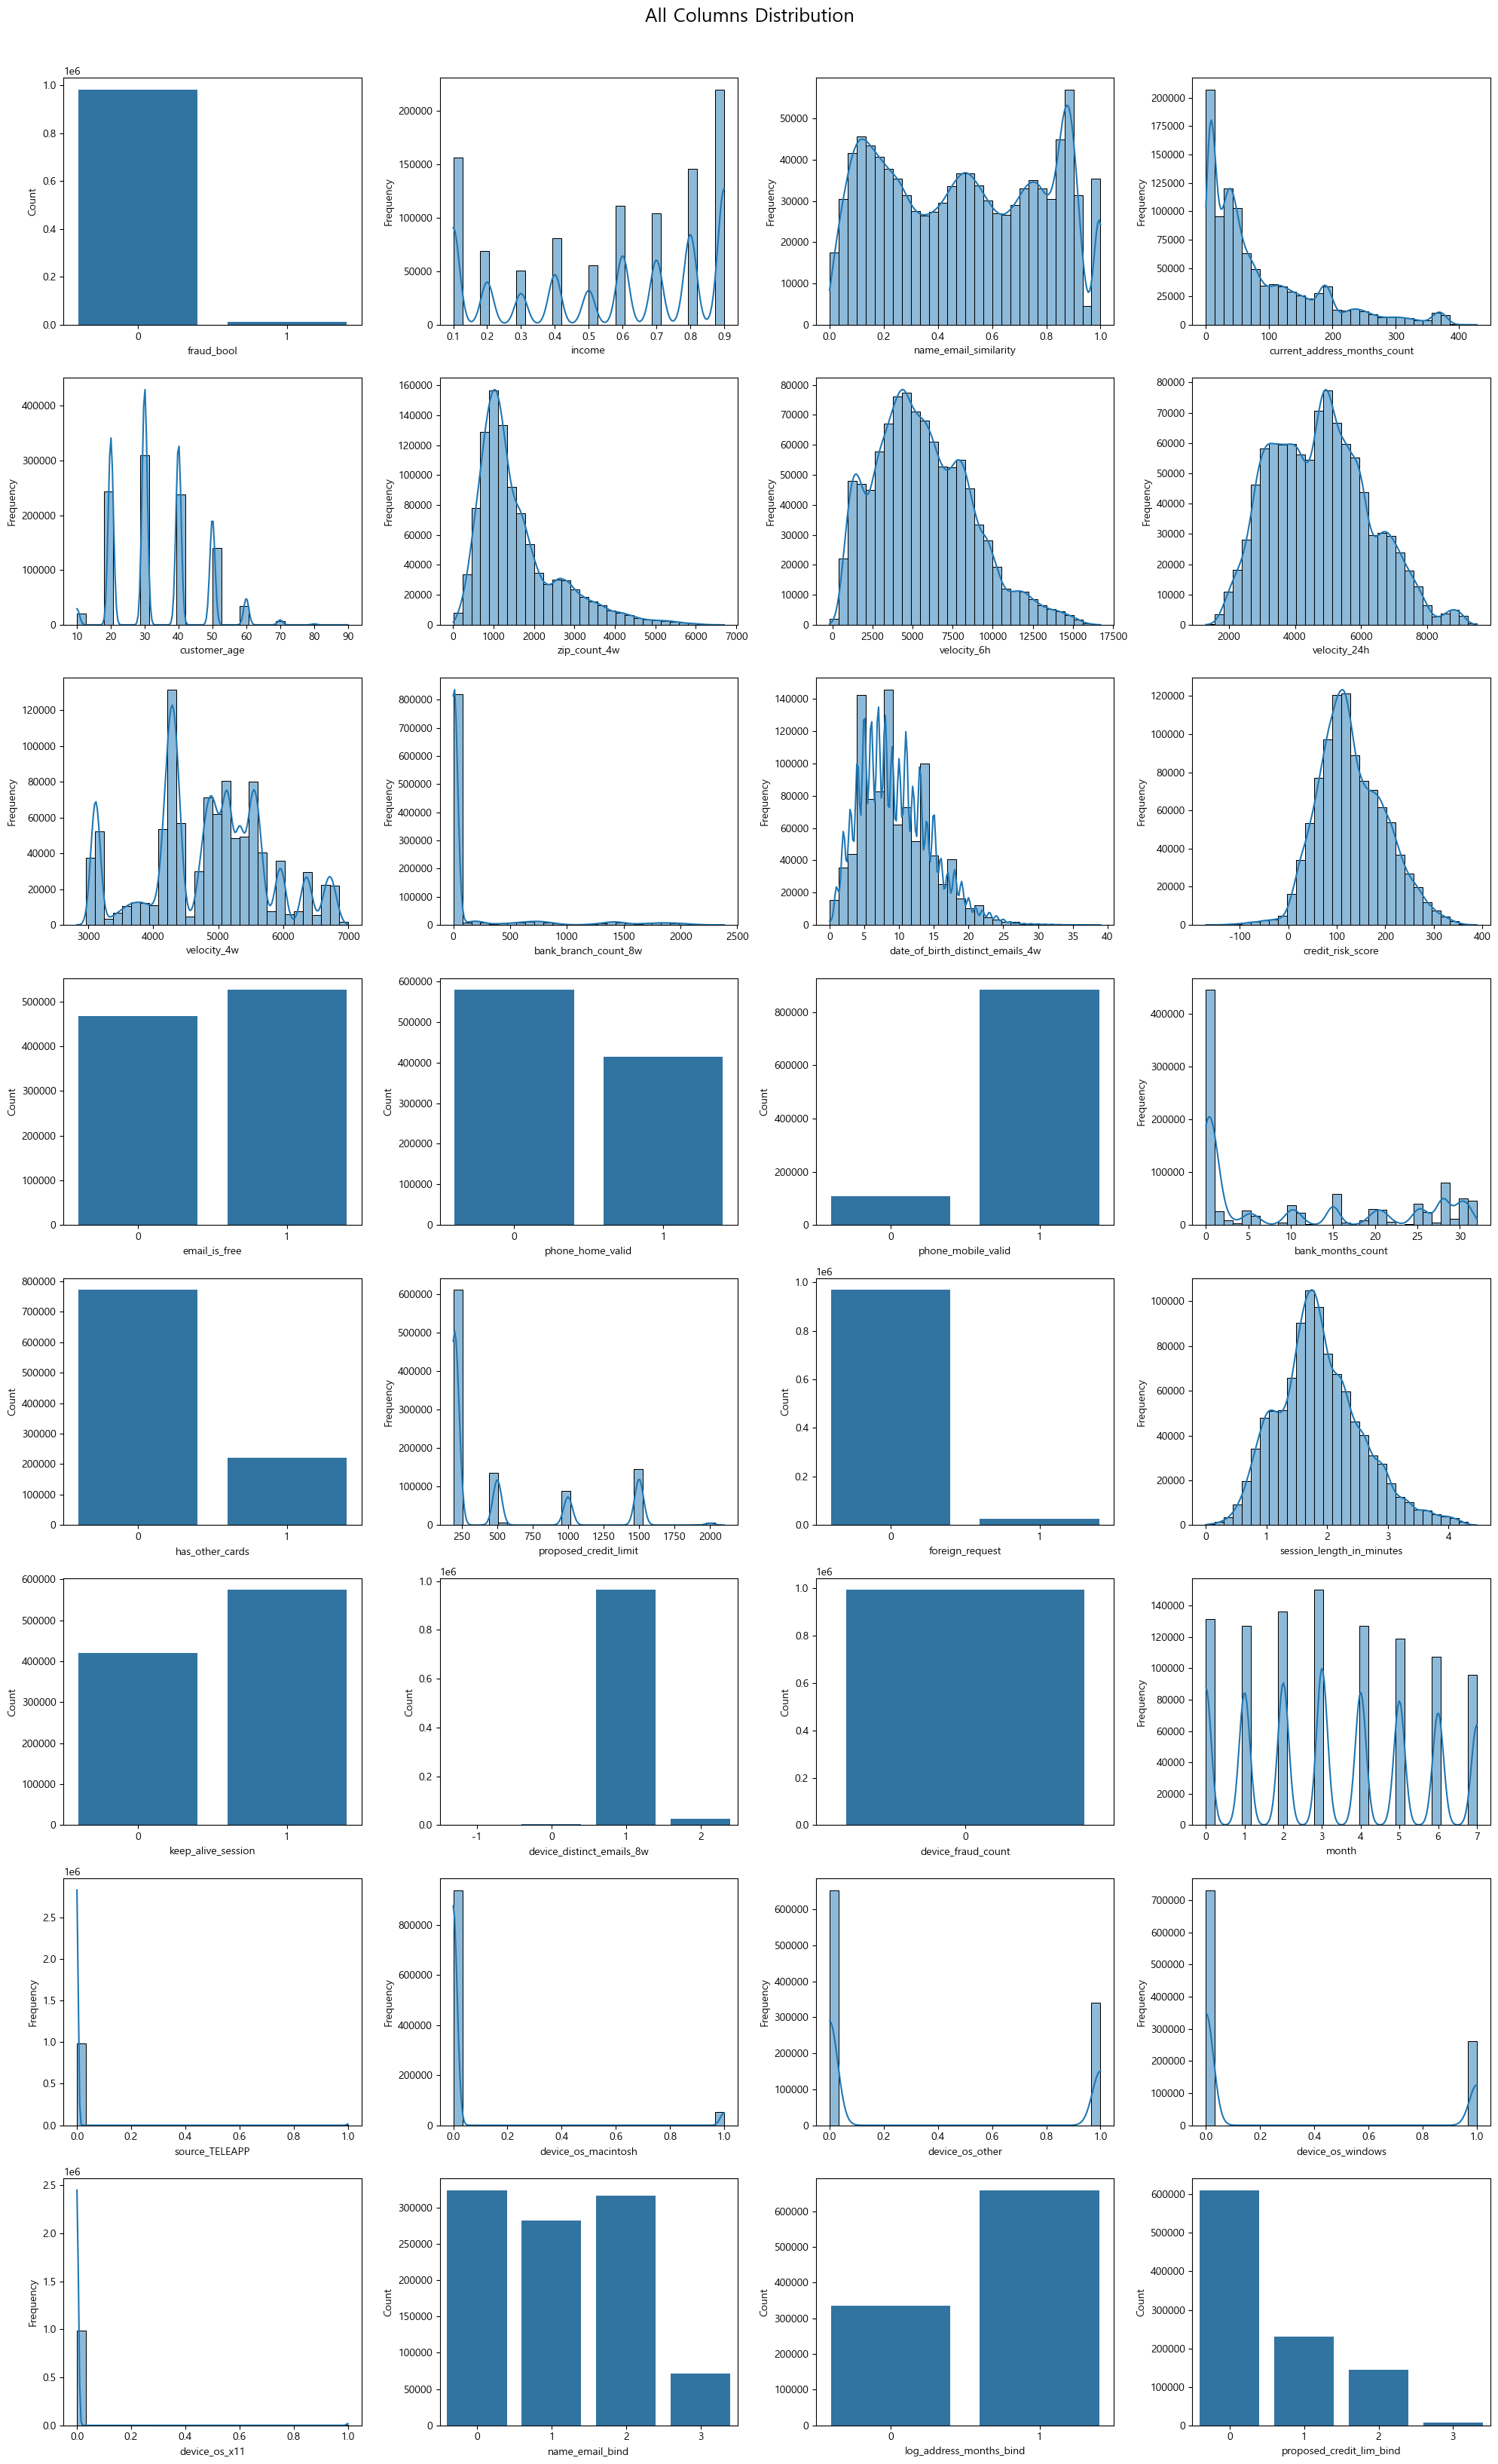

In [57]:
# #### Distribution of All Columns ###
num_cols = len(base_copy.columns)
x = 4
y = (num_cols + x - 1) // x 
plt.figure(figsize=(x * 5, y * 4))
for i, col in enumerate(base_copy.columns):
    plt.subplot(y, x, i + 1)

    if base_copy[col].nunique() < 5 and base_copy[col].dtype == 'int64':
            sns.countplot(x=col, data=base_copy)
            plt.xlabel(col, fontsize=10)
            plt.ylabel('Count', fontsize=10)

    else:
        sns.histplot(base_copy[col], kde=True, bins=30)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.suptitle('All Columns Distribution', y=1.02, fontsize=18) 
plt.show()

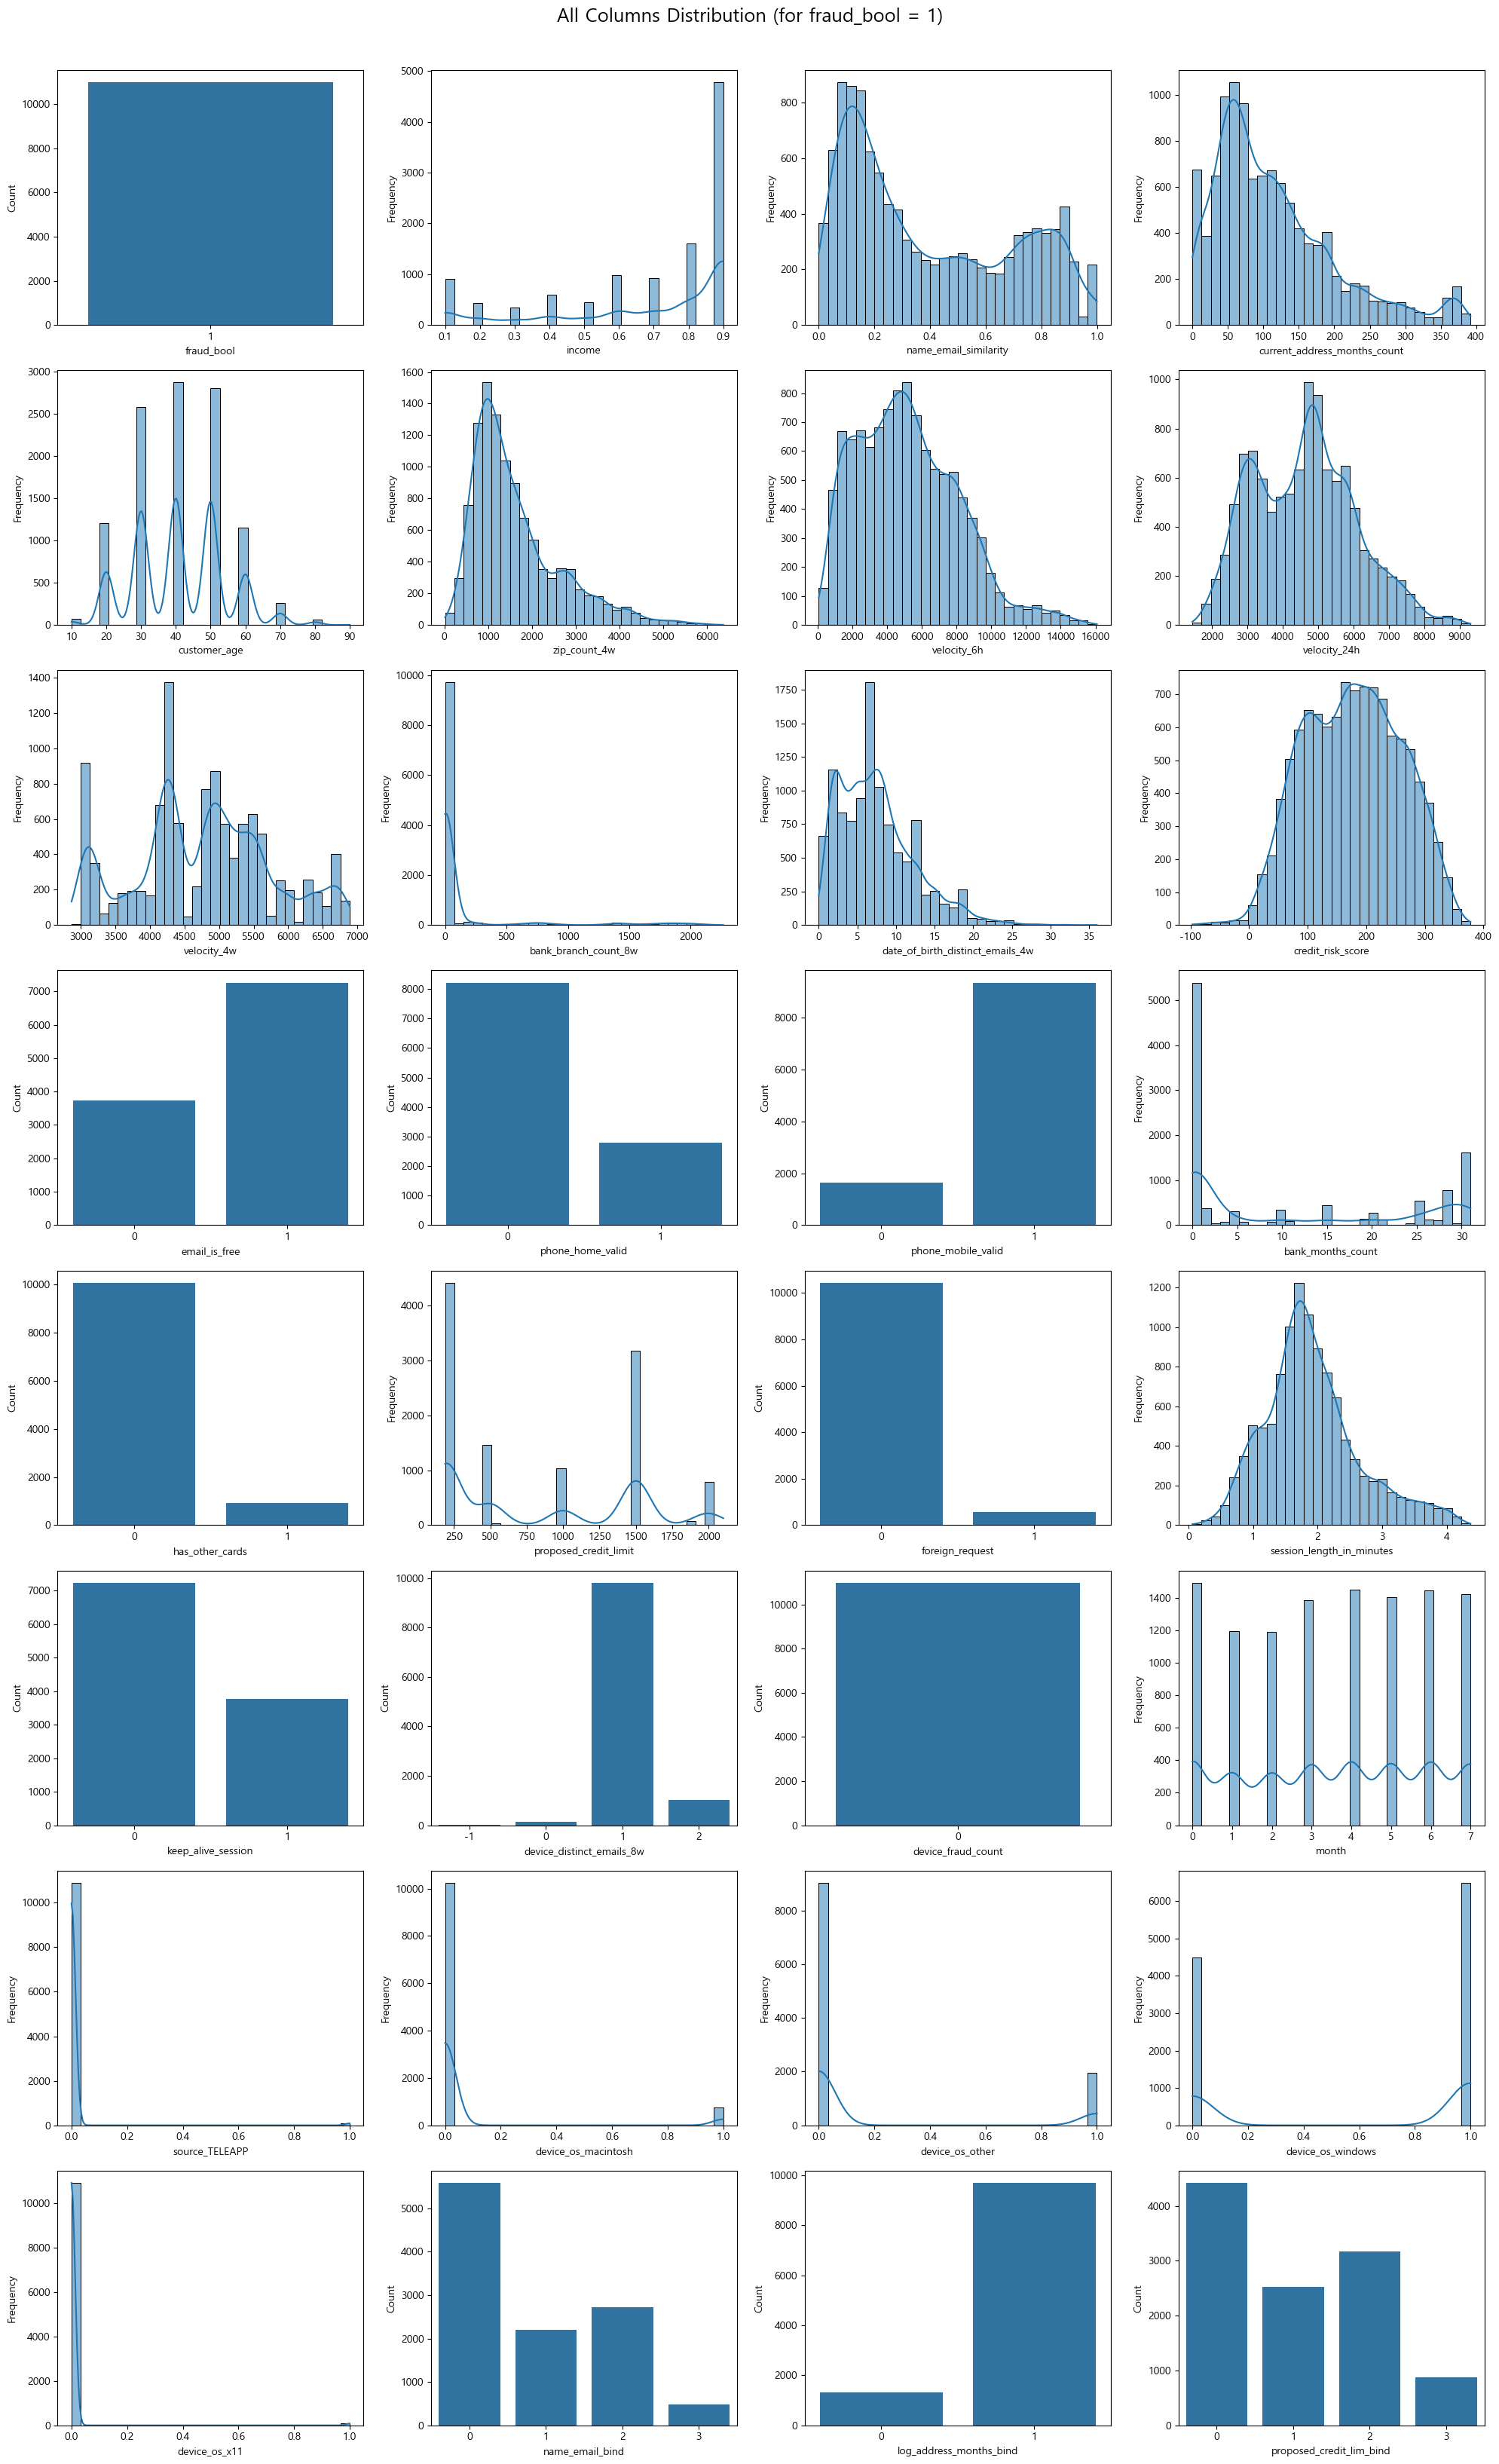

In [58]:
# --- fraud_bool이 1인 경우의 모든 컬럼 분포 시각화 ---
fraud_data = base_copy[base_copy['fraud_bool'] == 1]

# 사기 데이터셋에 대한 컬럼 수 계산 (동일할 수 있지만, 명시적으로 다시 계산)
num_fraud_cols = len(fraud_data.columns)
x_fraud = 4 # 동일한 레이아웃 유지
y_fraud_rows = (num_fraud_cols + x_fraud - 1) // x_fraud 

plt.figure(figsize=(x_fraud * 5, y_fraud_rows * 4))
for i, col in enumerate(fraud_data.columns):
    plt.subplot(y_fraud_rows, x_fraud, i + 1)

    # 이산형 변수 (카운트 플롯)와 연속형 변수 (히스토그램) 구분
    if fraud_data[col].nunique() < 5 and fraud_data[col].dtype == 'int64':
        sns.countplot(x=col, data=fraud_data)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Count', fontsize=10)
    else:
        sns.histplot(fraud_data[col], kde=True, bins=30)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.suptitle('All Columns Distribution (for fraud_bool = 1)', y=1.02, fontsize=18) 
plt.show()

In [19]:
base_copy['income'].value_counts().sort_index()

income
0.1    156375
0.2     68926
0.3     50496
0.4     80832
0.5     55493
0.6    111281
0.7    104487
0.8    145747
0.9    220098
Name: count, dtype: int64

In [30]:
def set_name_email_bind(similarity):
    if similarity < 0.3: 
        return 0
    elif 0.3 <= similarity < 0.6:
        return 1
    elif 0.6 <= similarity < 0.9:
        return 2
    else :
        return 3

base_copy['name_email_bind'] = base_copy['name_email_similarity'].apply(set_name_email_bind)

In [31]:
base_copy['name_email_bind'].value_counts().sort_index()

name_email_bind
0    324121
1    281846
2    316349
3     71419
Name: count, dtype: int64

In [32]:
import numpy as np
from numpy import log1p
base_copy['log_address_months'] = log1p(base_copy['current_address_months_count'])

Text(0, 0.5, 'Frequency')

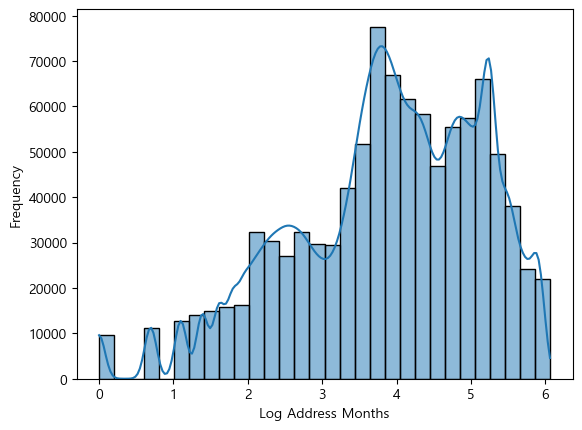

In [35]:
sns.histplot(base_copy['log_address_months'], kde=True, bins=30)
plt.xlabel('Log Address Months', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

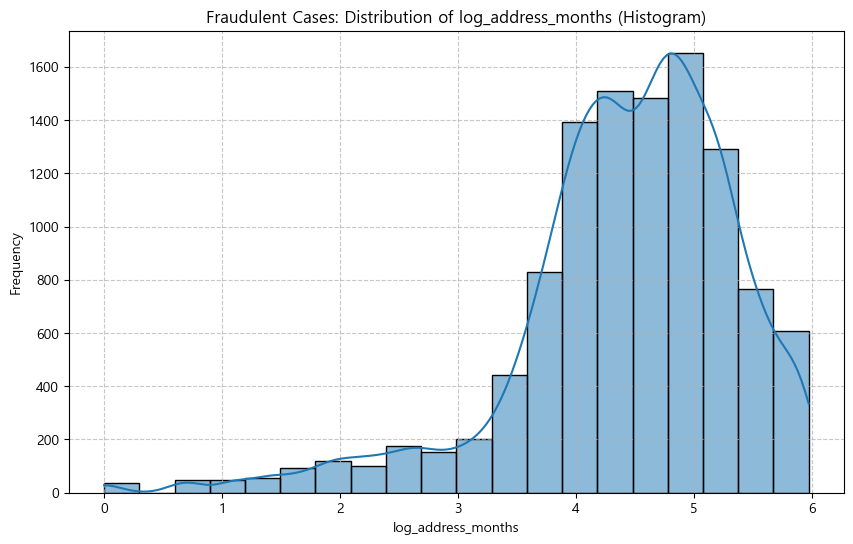

In [36]:
fraud_data = base_copy[base_copy['fraud_bool'] == 1]
plt.figure(figsize=(10, 6))
sns.histplot(fraud_data['log_address_months'], kde=True, bins=20) # kde=True는 커널 밀도 추정 그래프를 함께 보여줍니다.
plt.title('Fraudulent Cases: Distribution of log_address_months (Histogram)')
plt.xlabel('log_address_months')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [37]:
def log_address_months_bind(data):
    if data < 3.5: 
        return 0
    else:
        return 1

base_copy['log_address_months_bind'] = base_copy['log_address_months'].apply(log_address_months_bind)
base_copy.drop(columns=['log_address_months'], inplace=True)

In [38]:
base_copy['log_address_months_bind'].value_counts().sort_index()

log_address_months_bind
0    334556
1    659179
Name: count, dtype: int64

In [39]:
base_copy['session_length_in_minutes'] = log1p(base_copy['session_length_in_minutes'])

Text(0, 0.5, 'Frequency')

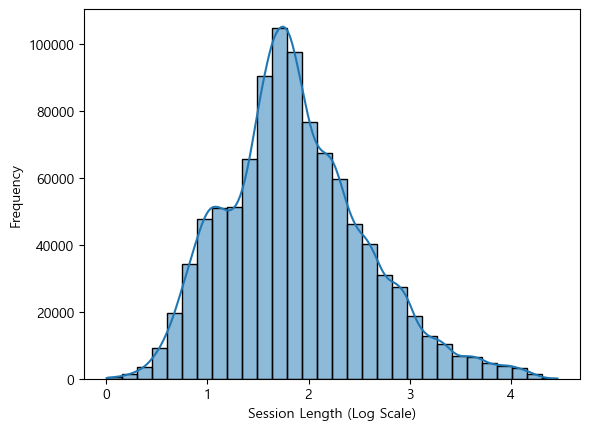

In [40]:
sns.histplot(base_copy['session_length_in_minutes'], kde=True, bins=30)
plt.xlabel('Session Length (Log Scale)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

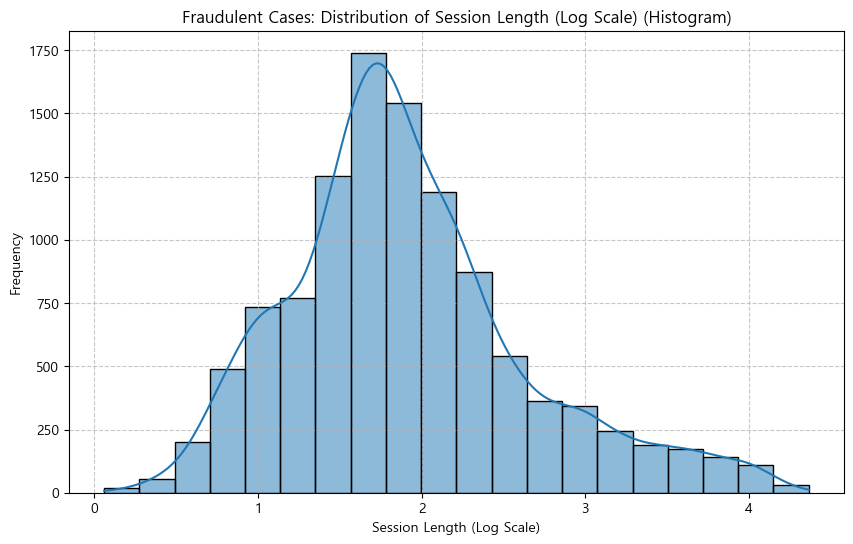

In [41]:
fraud_data = base_copy[base_copy['fraud_bool'] == 1]
plt.figure(figsize=(10, 6))
sns.histplot(fraud_data['session_length_in_minutes'], kde=True, bins=20) # kde=True는 커널 밀도 추정 그래프를 함께 보여줍니다.
plt.title('Fraudulent Cases: Distribution of Session Length (Log Scale) (Histogram)')
plt.xlabel('Session Length (Log Scale)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

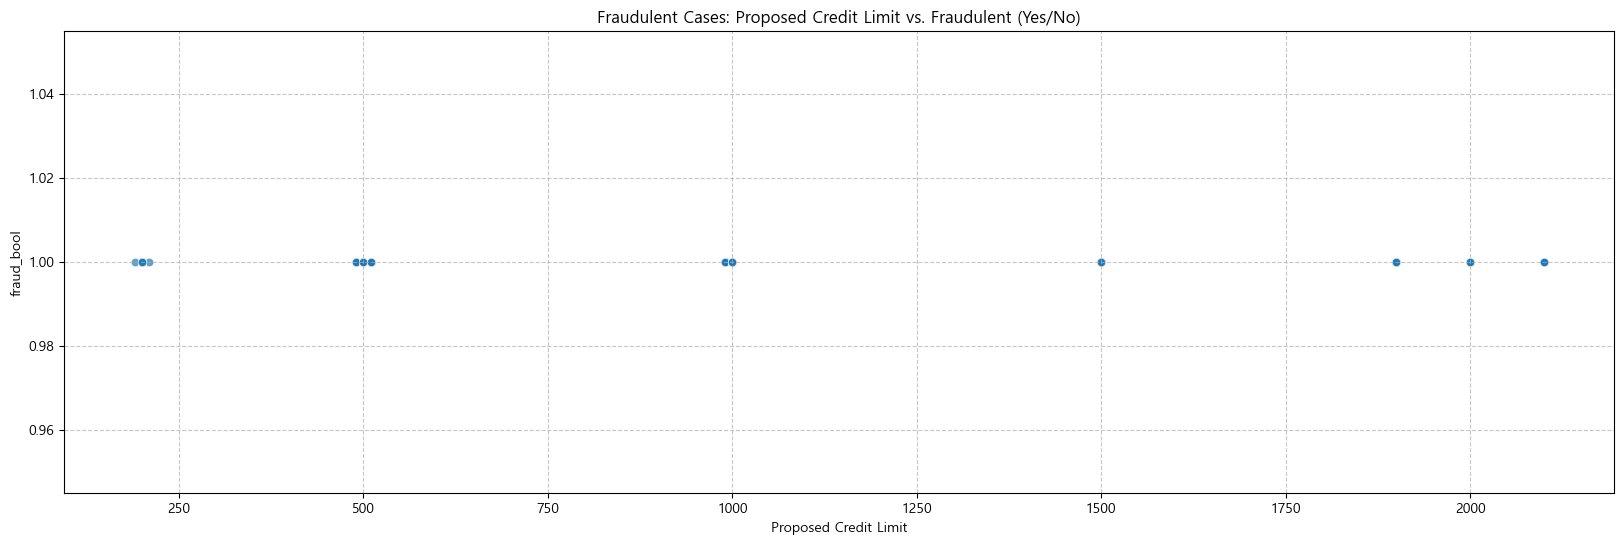

In [48]:

plt.figure(figsize=(20, 6))
sns.scatterplot(data=fraud_data, x='proposed_credit_limit',y='fraud_bool', alpha=0.7)
plt.title('Fraudulent Cases: Proposed Credit Limit vs. Fraudulent (Yes/No)')
plt.xlabel('Proposed Credit Limit')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [52]:
def proposed_credit_lim_bind(data):
    if data < 500: 
        return 0
    elif 500 <= data < 1500:
        return 1
    elif 1500 <= data < 1750:
        return 2
    else:
        return 3

base_copy['proposed_credit_lim_bind'] = base_copy['proposed_credit_limit'].apply(proposed_credit_lim_bind)

In [53]:
base_copy['proposed_credit_lim_bind'].value_counts().sort_index()

proposed_credit_lim_bind
0    611221
1    230937
2    145060
3      6517
Name: count, dtype: int64

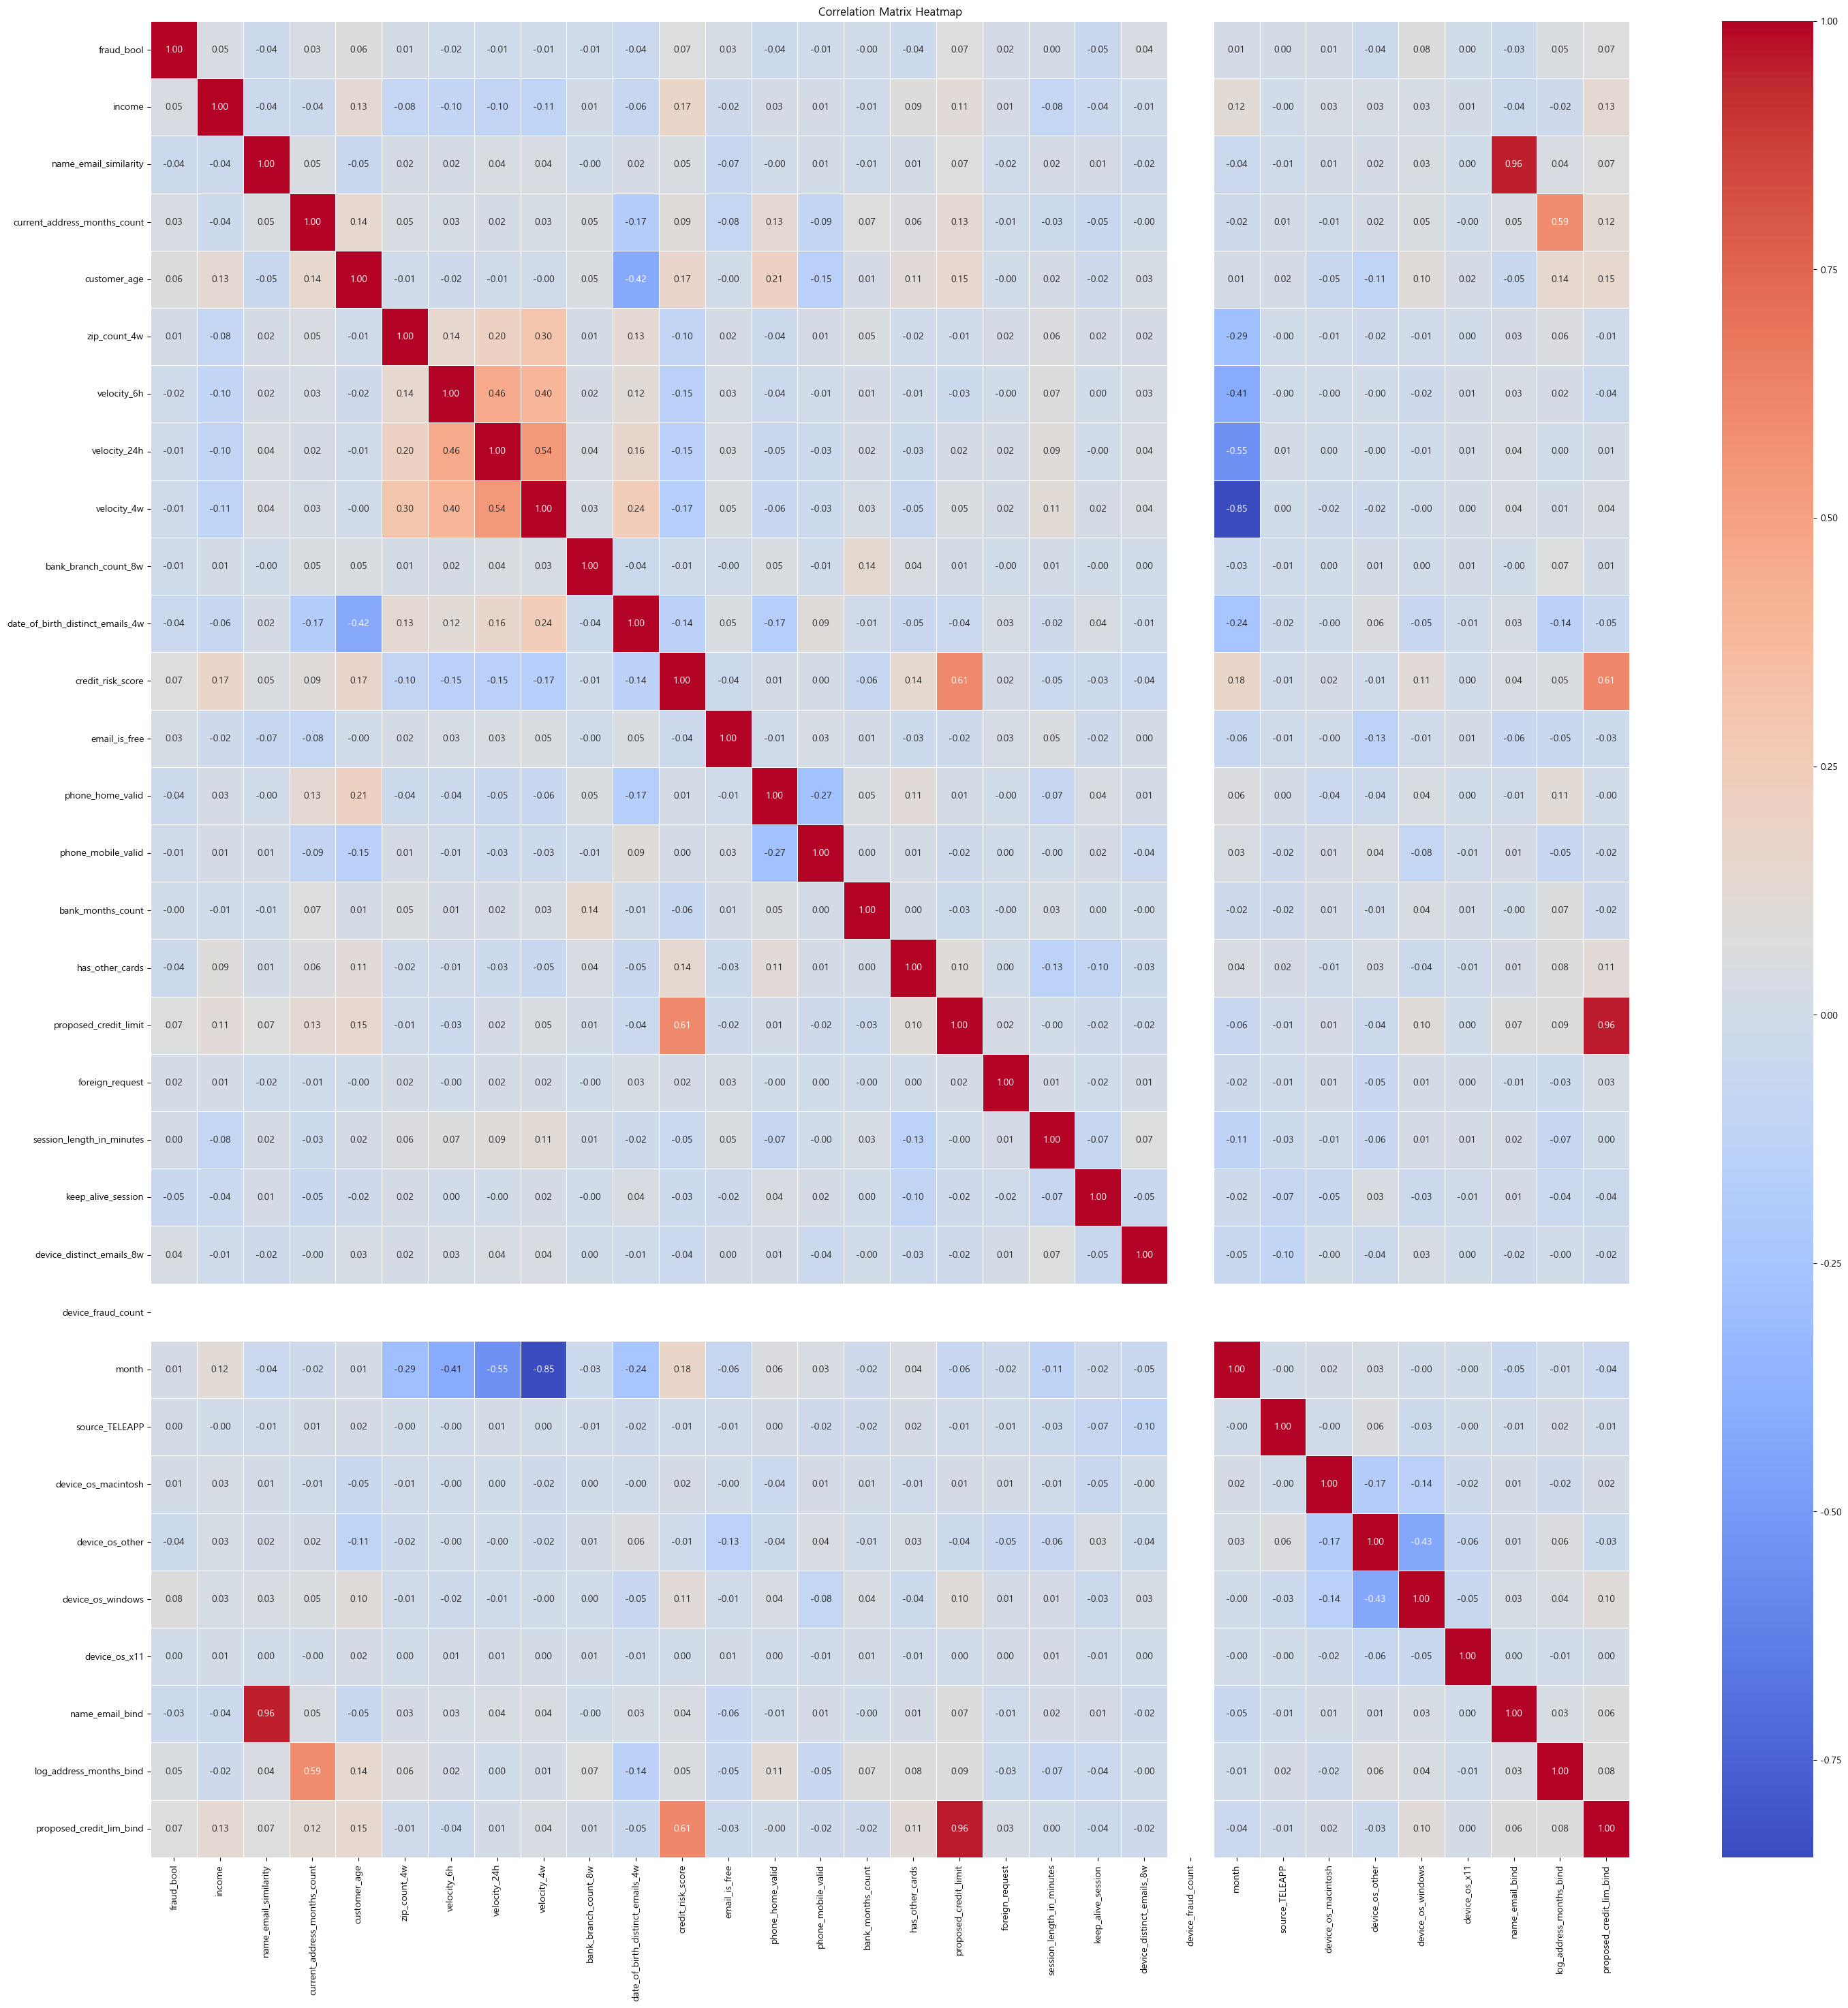

In [59]:

df = [base_copy]
for df in df:
    correlation_matrix = df.corr(numeric_only=True)
    plt.figure(figsize=(35, 35))
    sns.heatmap(
        correlation_matrix,  
        annot=True,          
        cmap='coolwarm',     
        fmt=".2f",          
        linewidths=.5,      
        cbar=True           
    )
    plt.title('Correlation Matrix Heatmap')
    plt.show()